# Adversarial Robustness Toolkit Membership Inference Attacks

Download data from https://physionet.org/content/mimic2-iaccd/1.0/ (https://physionet.org/content/mimic2-iaccd/1.0/full_cohort_data.csv to download the full_cohort data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

### Load data

In [2]:
path = "./data/mimic2-iaccd/1.0/"
data_path = os.path.join(path, "full_cohort_data.csv")
X = pd.read_csv(data_path)

In [3]:
X.shape

(1776, 46)

In [4]:
X.head()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_unit,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
0,1,7.63,13,72.36841,1.0,75.0,29.912791,15.0,9.0,SICU,...,354.0,138.0,4.6,15.0,109.0,41.0,1.6,196.0,39.0,2230.875000
1,0,1.14,1,64.92076,0.0,55.0,20.121312,NaN,5.0,MICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.000000
2,0,2.86,5,36.50000,0.0,70.0,27.118272,16.0,5.0,MICU,...,295.0,144.0,3.9,17.0,101.0,16.0,0.8,298.0,30.0,2086.800293
3,1,0.58,3,44.49191,0.0,NaN,NaN,21.0,7.0,SICU,...,262.0,139.0,4.2,31.0,100.0,16.0,0.5,146.0,23.0,NaN
4,1,1.75,5,23.74217,1.0,95.2,28.464563,18.0,7.0,SICU,...,22.0,146.0,3.4,19.0,110.0,10.0,1.0,134.0,30.0,2358.244141


In [5]:
X.describe()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_num,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
count,1776.000000,1776.000000,1776.000000,1776.000000,1775.000000,1666.000000,1310.000000,1691.000000,1770.000000,1776.000000,...,1768.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1770.000000,1590.000000,1590.000000,1633.000000
mean,0.554054,3.346498,8.110923,54.379660,0.577465,80.075948,27.827316,14.136606,5.820904,0.552928,...,246.083145,139.559006,4.107623,24.416657,103.839074,19.277809,1.095706,227.623270,43.413836,1622.907946
std,0.497210,3.356261,8.157159,21.062854,0.494102,22.490516,8.210074,4.114302,2.334666,0.497331,...,99.865469,4.726209,0.794724,4.992172,5.734283,14.366890,1.083477,144.863403,13.980786,1677.129157
min,0.000000,0.500000,1.000000,15.180230,0.000000,30.000000,12.784877,3.000000,0.000000,0.000000,...,7.000000,105.000000,1.900000,2.000000,78.000000,2.000000,0.000000,22.000000,8.000000,0.000000
25%,0.000000,1.370000,3.000000,38.247318,0.000000,65.400000,22.617307,11.000000,4.000000,0.000000,...,182.000000,137.000000,3.600000,22.000000,101.000000,11.000000,0.700000,108.000000,36.000000,329.750000
50%,1.000000,2.185000,6.000000,53.678585,1.000000,77.000000,26.324846,14.000000,6.000000,1.000000,...,239.000000,140.000000,4.000000,24.000000,104.000000,15.000000,0.900000,195.000000,41.000000,1081.529175
75%,1.000000,4.002500,10.000000,72.762992,1.000000,90.000000,30.796551,17.000000,7.000000,1.000000,...,297.000000,142.000000,4.400000,27.000000,107.000000,22.000000,1.100000,323.000000,47.000000,2493.900146
max,1.000000,28.240000,112.000000,99.110950,1.000000,257.600000,98.797134,32.000000,17.000000,1.000000,...,988.000000,165.000000,9.800000,62.000000,133.000000,139.000000,18.300000,634.000000,158.000000,13910.000000


In [6]:
for col in X.columns:
    print(col, X[col].isnull().sum().sum())

aline_flg 0
icu_los_day 0
hospital_los_day 0
age 0
gender_num 1
weight_first 110
bmi 466
sapsi_first 85
sofa_first 6
service_unit 0
service_num 0
day_icu_intime 0
day_icu_intime_num 0
hour_icu_intime 0
hosp_exp_flg 0
icu_exp_flg 0
day_28_flg 0
mort_day_censored 0
censor_flg 0
sepsis_flg 0
chf_flg 0
afib_flg 0
renal_flg 0
liver_flg 0
copd_flg 0
cad_flg 0
stroke_flg 0
mal_flg 0
resp_flg 0
map_1st 0
hr_1st 0
temp_1st 3
spo2_1st 0
abg_count 0
wbc_first 8
hgb_first 8
platelet_first 8
sodium_first 5
potassium_first 5
tco2_first 5
chloride_first 5
bun_first 5
creatinine_first 6
po2_first 186
pco2_first 186
iv_day_1 143


### Preprocess data

In [7]:
# remove columns non-numerical and repetitive or uninformative data for the analysis
col = ["service_unit", "day_icu_intime", "hosp_exp_flg", "icu_exp_flg", "day_28_flg"]
# service_num is the numerical version of service_unit
# day_icu_intime_num is the numerical version of day_icu_intime
# the other columns are to do with death and are somewhat repetitive with censor_flg
X = X.drop(col, axis=1)
# drop columns with only 1 value
X.drop("sepsis_flg", axis=1, inplace=True)

# Generic cleaning up (all data sets)
# drop NA by row
X.dropna(axis=0, inplace=True)

print(X.shape)

# Change it for each dataset
var = "censor_flg"  #'aline_flg'#

# Obtain labels and remove them from the data
y = X[var]
# Drop the column that contains the labels
X.drop([var], axis=1, inplace=True)

y = np.array(y, dtype=np.int8)
X = np.array(X, dtype=np.float64)
print(X.shape)

test_size = 0.2  # Define test size
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=test_size, random_state=58954
)

print(f"X_train = {X_train.shape}")
print(f"y_train = {y_train.shape}")
print(f"X_test = {X_test.shape}")
print(f"y_test = {y_test.shape}")


N_FEATURES = X_train.shape[1]
N_CLASSES = 2

(1064, 40)
(1064, 39)
X_train = (851, 39)
y_train = (851,)
X_test = (213, 39)
y_test = (213,)


### Helper functions

In [8]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import auc, RocCurveDisplay, DetCurveDisplay, det_curve, confusion_matrix
import numpy as np
from typing import Any, Iterable, Optional


def plot_confusion_matrix(name: str, 
                          confusion_matrix: Iterable[float],
                          n_classes:int,
                          normalize: bool = False,
                          cmap:Any = plt.cm.Blues,
                          save: Optional[str] = None) -> Any:
    """
    This function plots a confusion matrix for predictions of a given model.
    Name: is the name of the model.
    confusion_matrix: is the confusion matrix, e.g. output from confusion_matrix(y_test, y_pred).
    n_classes: is the number of classes, e.g. output of range(2).
    normalize: (boolean) whether to normalize the confusion matrix or not. Default False.
    cmap: is the colormap of the confusion matrix, default is cm.Blues.
    save: it save figure to the given path/figname. Default don't save.
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(n_classes) #np.arange(len(n_classes))
    plt.xticks(tick_marks, range(n_classes), rotation=45)
    plt.yticks(tick_marks, range(n_classes))

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
               horizontalalignment="center",
               color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(str(name)+' - Confusion matrix')

    if save:
        plt.savefig(save, bbox_inches='tight')
    #else:
    plt.show()


def plotROC_classifier(clf:Any,
                       X_tmp_test: Iterable[float], 
                       y_tmp_test: Iterable[float],
                       title:str = "ROC curve", 
                       save: Optional[str] = None):
    """
    This function calculates and plots a ROC AUC curve of a given model.
    clf: is the fitted classifier.
    X_tmp_test: test data.
    y_tmp_test: labels of test data.
    title: Set a title for the figure, e.g. specify model name/parameters etc. Default "ROC curve".
    save: it save figure to the given path/figname. Default don't save.
    """
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    viz = RocCurveDisplay.from_estimator(
            clf,
            X_tmp_test,
            y_tmp_test,
            name="ROC fold {}".format(0),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=title,
    )
    ax.legend(loc="lower right")

    if save:
        fig.savefig(save, bbox_inches='tight')
    #else:
    plt.show()


def calc_precision_recall(predicted, actual, positive_value=1):
    """Calculate the precision and recall"""
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = (
            score / num_positive_predicted
        )  # the fraction of predicted "Yes" responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = (
            score / num_positive_actual
        )  # the fraction of "Yes" responses that are predicted correctly
    return precision, recall

### RandomForestClassifier Target Model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

art_classifier = ScikitlearnRandomForestClassifier(model)

print(f"Base model accuracy: {model.score(X_test, y_test)}")

Base model accuracy: 1.0


/home/r2-preen/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       154

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

Confusion matrix, without normalization


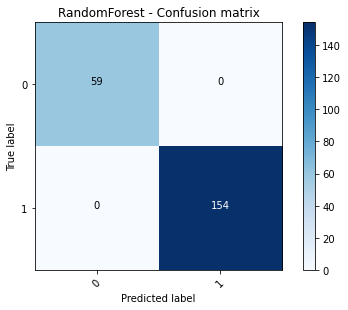

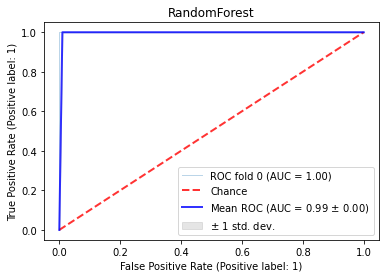

In [10]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
name = "RandomForest"
plot_confusion_matrix(name, confusion_matrix(y_test, y_pred), 2)
plotROC_classifier(model, X_test, y_test, name)

### ART black-box attacks

In [11]:
from art.attacks.inference.membership_inference import (
    MembershipInferenceBlackBoxRuleBased, MembershipInferenceBlackBox
)


def art_black_box(attack, X_train, y_train) -> None:
    """Perform black-box membership inference."""
    # infer attacked feature
    inferred_train = attack.infer(X_train, y_train)
    inferred_test = attack.infer(X_test, y_test)
    # check accuracy
    train_acc = np.sum(inferred_train) / len(inferred_train)
    test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
    acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (
        len(inferred_train) + len(inferred_test)
    )
    acc *= 100  # convert fraction to percentage
    print("Rule-based attack")
    print(f"Train accuracy: {train_acc}")
    print(f"Test accuracy: {test_acc}")
    print(f"For {acc:.2f}% of the data, membership status is inferred correctly.")
    print(
        calc_precision_recall(
            np.concatenate((inferred_train, inferred_test)),
            np.concatenate((np.ones(len(inferred_train)), np.zeros(len(inferred_test)))),
        )
    )

### Rule-based attack on RandomForestClassifier
The rule-based attack uses the simple rule to determine membership in the training data: if the model's prediction for a sample is correct, then it is a member. Otherwise, it is not a member.

In [12]:
attack = MembershipInferenceBlackBoxRuleBased(art_classifier)

art_black_box(attack, X_train, y_train)

Rule-based attack
Train accuracy: 1.0
Test accuracy: 0.0
For 79.98% of the data, membership status is inferred correctly.
(0.799812030075188, 1.0)


### Black-box attack on RandomForestClassifier
The black-box attack trains an additional classifier (the attack model) to predict the membership status of a sample. It can use as input to the learning process probabilities/logits or losses, depending on the type of model and provided configuration.

In [13]:
attack = MembershipInferenceBlackBox(art_classifier)

attack.fit(X_train, y_train, X_test, y_test)

art_black_box(attack, X_train, y_train)

Rule-based attack
Train accuracy: 0.9882491186839013
Test accuracy: 0.3755868544600939
For 86.56% of the data, membership status is inferred correctly.
(0.8634496919917864, 0.9882491186839013)


### Neural Network Target Model

In [14]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from art.estimators.classification import KerasClassifier

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(N_FEATURES, )),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Train on 851 samples
Epoch 1/100
851/851 [==============================] - 0s 86us/sample - loss: 6.2284 - accuracy: 0.6052
Epoch 2/100
851/851 [==============================] - 0s 89us/sample - loss: 6.2503 - accuracy: 0.6052
Epoch 3/100
851/851 [==============================] - 0s 101us/sample - loss: 5.3432 - accuracy: 0.6604
Epoch 4/100
851/851 [==============================] - 0s 99us/sample - loss: 4.6569 - accuracy: 0.7027
Epoch 5/100
851/851 [==============================] - 0s 101us/sample - loss: 4.0115 - accuracy: 0.7438
Epoch 6/100
851/851 [==============================] - 0s 99us/sample - loss: 2.9186 - accuracy: 0.8120
Epoch 7/100
851/851 [==============================] - 0s 99us/sample - loss: 2.5630 - accuracy: 0.8367
Epoch 8/100
851/851 [==============================] - 0s 101us/sample - loss: 2.1614 - accuracy: 0.8613
Epoch 9/100
851/851 [==============================] - 0s 100us/sample - loss: 2.0728 - accuracy: 0.8649
Epoch 10/100
851/851 [=================

851/851 [==============================] - 0s 100us/sample - loss: 0.6484 - accuracy: 0.9577
Epoch 79/100
851/851 [==============================] - 0s 99us/sample - loss: 0.7255 - accuracy: 0.9518
Epoch 80/100
851/851 [==============================] - 0s 101us/sample - loss: 0.8367 - accuracy: 0.9459
Epoch 81/100
851/851 [==============================] - 0s 100us/sample - loss: 0.6568 - accuracy: 0.9577
Epoch 82/100
851/851 [==============================] - 0s 100us/sample - loss: 0.5357 - accuracy: 0.9659
Epoch 83/100
851/851 [==============================] - 0s 99us/sample - loss: 0.6129 - accuracy: 0.9589
Epoch 84/100
851/851 [==============================] - 0s 104us/sample - loss: 0.5530 - accuracy: 0.9647
Epoch 85/100
851/851 [==============================] - 0s 100us/sample - loss: 0.6292 - accuracy: 0.9600
Epoch 86/100
851/851 [==============================] - 0s 100us/sample - loss: 0.6850 - accuracy: 0.9542
Epoch 87/100
851/851 [==============================] - 0s 98

In [15]:
loss_test, accuracy_test = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {(accuracy_test * 100):4.2f}%")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Accuracy on test data: 98.59%


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.98      1.00      0.99       154

    accuracy                           0.99       213
   macro avg       0.99      0.97      0.98       213
weighted avg       0.99      0.99      0.99       213

Confusion matrix, without normalization


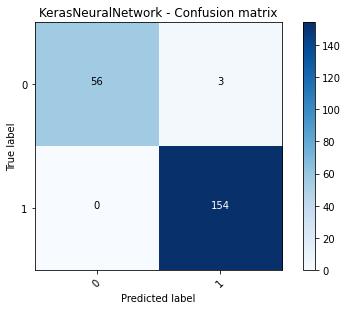

In [16]:
y_pred = model.predict(X_test)

y_pred = y_pred.argmax(axis=-1)

print(classification_report(y_test, y_pred))
name = "KerasNeuralNetwork"
plot_confusion_matrix(name, confusion_matrix(y_test, y_pred), 2)

### Rule-based attack on keras neural network

In [17]:
art_classifier = KerasClassifier(model)

attack = MembershipInferenceBlackBoxRuleBased(art_classifier)

art_black_box(attack, X_train, y_train)

Rule-based attack
Train accuracy: 0.9753231492361927
Test accuracy: 0.014084507042253502
For 78.29% of the data, membership status is inferred correctly.
(0.7980769230769231, 0.9753231492361927)


### Black-box attack on keras neural network

In [18]:
attack = MembershipInferenceBlackBox(art_classifier)

attack.fit(X_train, y_train, X_test, y_test)

art_black_box(attack, X_train, y_train)

Rule-based attack
Train accuracy: 1.0
Test accuracy: 0.0
For 79.98% of the data, membership status is inferred correctly.
(0.799812030075188, 1.0)
